In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns

# Data

I performed an open ionbot and msfragger search (oxididation of M variable, max 2 missed cleavages).

See SOP document for more details on how MSFragger was ran.

In [15]:
#set this your local folder as the data was pushed to the repo as well
folder = "/home/compomics/tools/ionbot_paper"
datasets = ["PXD001468","PXD000561","PXD000815","PXD001250","TMTCPTAC"]
#datasets = ["PXD001468","PXD000815"]


 # Results
 
Load ionbot PSM results (first-matches + coeluting matches + features) + protein results.

In [16]:
def contains_missed_cleavage(x):
    if "K" in x[:-1]:
        return True
    if "R" in x[:-1]:
        return True
    return False

def is_in_s(x):
    return x in s

In [17]:
results = {}
for datas in datasets:
    for suffix in ["","_nort","_nocorr","_nocorr_nort","_closed"]:
        dataset = datas + suffix
        print(dataset)
        #Processing dataset
        if "PXD001468" in dataset:
            def get_scan_ionbot(x):
                return int(x.split('.')[1])
            def get_spectrum_file_ionbot(x):
                return x.split('.')[0]
        else:
            def get_scan_ionbot(x):
                print(x)
                return int(x.split('=')[-1])
            def get_spectrum_file_ionbot(x):
                return x.split('.')[0]
        folder2 = folder + "/" + dataset
        ionbot = pd.read_csv("%s/ionbot.first.csv"%folder2)
        ionbot["rank"] = ["first"]*len(ionbot)
        tmp = pd.read_csv("%s/ionbot.lower.csv"%folder2)
        tmp["rank"] = ["lower"]*len(tmp)
        ionbot = pd.concat([ionbot,tmp])
        tmp = pd.read_csv("%s/ionbot.features.csv"%folder2)
        ionbot = ionbot.merge(tmp,on="ionbot_match_id",how="left")
        ionbot = ionbot[(ionbot["database"]=="T")&(ionbot["q-value"]<=0.01)]
        if "PXD001468" in dataset:
            ionbot["scan"] = ionbot["spectrum_title"].apply(get_scan_ionbot)
            ionbot["sfile"] = ionbot["spectrum_title"].apply(get_spectrum_file_ionbot)
        else:
            ionbot["sfile"] = ionbot["spectrum_file"].apply(get_spectrum_file_ionbot)
        ionbot["PSM"] = ionbot["scan"].astype(str) + ionbot["sfile"] +  "XYX" +  ionbot["matched_peptide"]
        ionbot["contains_missed_cleavage"] = ionbot["matched_peptide"].apply(contains_missed_cleavage)    
        ionbot["num_passed"] = ionbot.groupby(["sfile","scan"])["scan"].transform("count")
        ionbot = ionbot[(ionbot["num_passed"]==1) |
                (ionbot["rank"]=="lower") |
                ((ionbot["num_passed"]>1) & (ionbot["rank"]=="first") & (ionbot["unexpected_modification"].isna()) & (ionbot["contains_missed_cleavage"]==False))]
        #need to re-assign best_psm
        best_psms = ionbot.sort_values("psm_score").drop_duplicates(["sfile","scan"], keep="last")
        best_psm_ids = set(best_psms["ionbot_match_id"])
        ionbot["rank"] = ionbot["ionbot_match_id"].apply(
        lambda x: "first" if x in best_psm_ids else "lower")    
        results[dataset] = ionbot


PXD001468
PXD001468_nort
PXD001468_nocorr
PXD001468_nocorr_nort
PXD001468_closed
PXD000561
PXD000561_nort
PXD000561_nocorr
PXD000561_nocorr_nort
PXD000561_closed
PXD000815
PXD000815_nort
PXD000815_nocorr
PXD000815_nocorr_nort
PXD000815_closed
PXD001250
PXD001250_nort
PXD001250_nocorr
PXD001250_nocorr_nort
PXD001250_closed
TMTCPTAC
TMTCPTAC_nort
TMTCPTAC_nocorr
TMTCPTAC_nocorr_nort
TMTCPTAC_closed


In [24]:
def is_in_s(x):
    return x in s

to_write = []

for datas in datasets:
    dataset = datas
    #compute statistics
    print(dataset)

    dataset = datas + "_closed"
    ionbot = results[dataset]
    full = len(ionbot)
    to_write.append(["","count","PSM",datas,"_closed",full])

    dataset = datas
    ionbot = results[dataset]
    ionbot["massdiff"] = np.abs(ionbot["precursor_mass"]-ionbot["peptide_mass"])
    ionbot["is_7Da"] = ((ionbot["unexpected_modification"].isna()) & (ionbot["massdiff"]>0.2))
    full = len(ionbot[ionbot["rank"]=="first"])
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)])
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())])
    to_write.append(["","count","PSM",datas,"_open",full-wide-unexp])
    to_write.append(["is_7Da","count","PSM",datas,"_open",wide])
    to_write.append(["is_unexpected","count","PSM",datas,"_open",unexp])
    full = len(ionbot[ionbot["rank"]=="first"]["matched_peptide"].unique())
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)]["matched_peptide"].unique())
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())]["matched_peptide"].unique())
    to_write.append(["","count","peptide",datas,"_open",full-wide-unexp])
    to_write.append(["is_7Da","count","peptide",datas,"_open",wide])
    to_write.append(["is_unexpected","count","peptide",datas,"_open",unexp])

    dataset = datas + "_nort"
    ionbot = results[dataset]
    ionbot["massdiff"] = np.abs(ionbot["precursor_mass"]-ionbot["peptide_mass"])
    ionbot["is_7Da"] = ((ionbot["unexpected_modification"].isna()) & (ionbot["massdiff"]>0.2))
    full = len(ionbot[ionbot["rank"]=="first"])
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)])
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())])
    to_write.append(["","count","PSM",datas,"_open_noR",full-wide-unexp])
    to_write.append(["is_7Da","count","PSM",datas,"_open_noR",wide])
    to_write.append(["is_unexpected","count","PSM",datas,"_open_noR",unexp])
    full = len(ionbot[ionbot["rank"]=="first"]["matched_peptide"].unique())
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)]["matched_peptide"].unique())
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())]["matched_peptide"].unique())
    to_write.append(["","count","peptide",datas,"_open_noR",full-wide-unexp])
    to_write.append(["is_7Da","count","peptide",datas,"_open_noR",wide])
    to_write.append(["is_unexpected","count","peptide",datas,"_open_noR",unexp])

    dataset = datas + "_nocorr"
    ionbot = results[dataset]
    ionbot["massdiff"] = np.abs(ionbot["precursor_mass"]-ionbot["peptide_mass"])
    ionbot["is_7Da"] = ((ionbot["unexpected_modification"].isna()) & (ionbot["massdiff"]>0.2))
    full = len(ionbot[ionbot["rank"]=="first"])
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)])
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())])
    to_write.append(["","count","PSM",datas,"_open_no_corr",full-wide-unexp])
    to_write.append(["is_7Da","count","PSM",datas,"_open_no_corr",wide])
    to_write.append(["is_unexpected","count","PSM",datas,"_open_no_corr",unexp])
    full = len(ionbot[ionbot["rank"]=="first"]["matched_peptide"].unique())
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)]["matched_peptide"].unique())
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())]["matched_peptide"].unique())
    to_write.append(["","count","peptide",datas,"_open_no_corr",full-wide-unexp])
    to_write.append(["is_7Da","count","peptide",datas,"_open_no_corr",wide])
    to_write.append(["is_unexpected","count","peptide",datas,"_open_no_corr",unexp])

    dataset = datas + "_nocorr_nort"
    ionbot = results[dataset]
    ionbot["massdiff"] = np.abs(ionbot["precursor_mass"]-ionbot["peptide_mass"])
    ionbot["is_7Da"] = ((ionbot["unexpected_modification"].isna()) & (ionbot["massdiff"]>0.2))
    full = len(ionbot[ionbot["rank"]=="first"])
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)])
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())])
    to_write.append(["","count","PSM",datas,"_open_noR_no_corr",full-wide-unexp])
    to_write.append(["is_7Da","count","PSM",datas,"_open_noR_no_corr",wide])
    to_write.append(["is_unexpected","count","PSM",datas,"_open_noR_no_corr",unexp])
    full = len(ionbot[ionbot["rank"]=="first"]["matched_peptide"].unique())
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)]["matched_peptide"].unique())
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())]["matched_peptide"].unique())
    to_write.append(["","count","peptide",datas,"_open_noR_no_corr",full-wide-unexp])
    to_write.append(["is_7Da","count","peptide",datas,"_open_noR_no_corr",wide])
    to_write.append(["is_unexpected","count","peptide",datas,"_open_noR_no_corr",unexp])

    #overlap between open and open without corr and rt information
    dataset = datas
    ionbot = results[dataset]
    s1 = set(ionbot[ionbot["rank"]=="first"]["PSM"])
    dataset = datas + "_nocorr_nort"
    ionbot = results[dataset]
    s2 = set(ionbot[ionbot["rank"]=="first"]["PSM"])
    to_write.append(["","overlap_open_noR_no_corr","PSM",datas,"_open",len(s1.difference(s2))])
    to_write.append(["","overlap_open_noR_no_corr","PSM",datas,"intersection",len(s1.intersection(s2))])
    uniques2 = len(s2.difference(s1))
    tmp = s1.difference(s2)
    #now I cut the peptide bacause I want the overlap in title
    tmp2 = []
    for s in tmp:
        tmp2.append(s.split("XYX")[0])
    tmp2 = set(tmp2)
    tmp = s2.difference(s1)
    #now I cut the peptide bacause I want the overlap in title
    tmp3 = []
    for s in tmp:
        tmp3.append(s.split("XYX")[0])
    tmp3 = set(tmp3)
    overruled = len(tmp2.intersection(tmp3))
    to_write.append(["","overlap_open_noR_no_corr","PSM",datas,"_open_noR_no_corr",uniques2-overruled])
    to_write.append(["overruled","overlap_open_noR_no_corr","PSM",datas,"_open_noR_no_corr",overruled])

    #overlap between open and closed
    dataset = datas
    ionbot = results[dataset]
    s1 = set(ionbot[ionbot["rank"]=="first"]["PSM"])
    dataset = datas + "_closed"
    ionbot = results[dataset]
    s2 = set(ionbot["PSM"])
    to_write.append(["","overlap_closed","PSM",datas,"intersection",len(s1.intersection(s2))])

    uniques2 = len(s2.difference(s1))
    tmp = s1.difference(s2)
    #now I cut the peptide bacause I want the overlap in title
    tmp2 = []
    for s in tmp:
        tmp2.append(s.split("XYX")[0])
    tmp2 = set(tmp2)
    tmp = s2.difference(s1)
    #now I cut the peptide bacause I want the overlap in title
    tmp3 = []
    for s in tmp:
        tmp3.append(s.split("XYX")[0])
    tmp3 = set(tmp3)
    overruled = len(tmp2.intersection(tmp3))
    to_write.append(["","overlap_closed","PSM",datas,"_closed",uniques2-overruled])
    to_write.append(["overruled","overlap_closed","PSM",datas,"_closed",overruled])

    dataset = datas
    ionbot = results[dataset]
    s = s1
    ionbot["unique"] = ionbot["PSM"].apply(is_in_s)
    ionbot = ionbot[ionbot["unique"]==True]
    ionbot["massdiff"] = np.abs(ionbot["precursor_mass"]-ionbot["peptide_mass"])
    ionbot["is_7Da"] = ((ionbot["unexpected_modification"].isna()) & (ionbot["massdiff"]>0.2))
    full = len(ionbot[ionbot["rank"]=="first"])
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)])
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())])
    to_write.append(["","overlap_closed","PSM",datas,"_open",full-wide-unexp])
    to_write.append(["is_7Da","overlap_closed","PSM",datas,"_open",wide])
    to_write.append(["is_unexpected","overlap_closed","PSM",datas,"_open",unexp])
    full = len(ionbot[ionbot["rank"]=="first"]["matched_peptide"].unique())
    wide = len(ionbot[(ionbot["rank"]=="first")&(ionbot["is_7Da"]==True)]["matched_peptide"].unique())
    unexp = len(ionbot[(ionbot["rank"]=="first")&(ionbot["unexpected_modification"].notna())]["matched_peptide"].unique())
    to_write.append(["","overlap_closed","peptide",datas,"_open",full-wide-unexp])
    to_write.append(["is_7Da","overlap_closed","peptide",datas,"_open",wide])
    to_write.append(["is_unexpected","overlap_closed","peptide",datas,"_open",unexp])





PXD001468
37105


/tmp/ipykernel_3509698/913948009.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ionbot["massdiff"] = np.abs(ionbot["precursor_mass"]-ionbot["peptide_mass"])
/tmp/ipykernel_3509698/913948009.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ionbot["is_7Da"] = ((ionbot["unexpected_modification"].isna()) & (ionbot["massdiff"]>0.2))


PXD000561
70422
PXD000815
19200
PXD001250
6570
TMTCPTAC
45822


In [26]:
to_write = pd.DataFrame(to_write,columns=["unexpected","type","level","spectrum_file","search","value"])
to_write.to_csv("id_overlap.csv",index=False)

In [25]:
to_write

[['', 'count', 'PSM', 'PXD001468', '_closed', 462664],
 ['', 'count', 'PSM', 'PXD001468', '_open', 411971],
 ['is_7Da', 'count', 'PSM', 'PXD001468', '_open', 156443],
 ['is_unexpected', 'count', 'PSM', 'PXD001468', '_open', 138096],
 ['', 'count', 'peptide', 'PXD001468', '_open', 30714],
 ['is_7Da', 'count', 'peptide', 'PXD001468', '_open', 70422],
 ['is_unexpected', 'count', 'peptide', 'PXD001468', '_open', 52376],
 ['', 'count', 'PSM', 'PXD001468', '_open_noR', 398686],
 ['is_7Da', 'count', 'PSM', 'PXD001468', '_open_noR', 143678],
 ['is_unexpected', 'count', 'PSM', 'PXD001468', '_open_noR', 136951],
 ['', 'count', 'peptide', 'PXD001468', '_open_noR', 31175],
 ['is_7Da', 'count', 'peptide', 'PXD001468', '_open_noR', 65814],
 ['is_unexpected', 'count', 'peptide', 'PXD001468', '_open_noR', 52330],
 ['', 'count', 'PSM', 'PXD001468', '_open_no_corr', 388321],
 ['is_7Da', 'count', 'PSM', 'PXD001468', '_open_no_corr', 135201],
 ['is_unexpected', 'count', 'PSM', 'PXD001468', '_open_no_corr'

Filter for identified matches.

This reads the PSM results from the full MSFragger pipeline:

In [20]:
fragger = pd.read_csv("%s/msfragger/%s/noprotein/psm.tsv"%(folder,dataset),sep="\t")
len(fragger)

FileNotFoundError: [Errno 2] No such file or directory: '/home/compomics/tools/ionbot_paper/msfragger/TMTCPTAC/noprotein/psm.tsv'

In [ ]:
def get_scan_msfragger(x):
    return int(x.split('.')[-2])
def get_spectrum_file_msfragger(x):
    return x.split('.')[0]
fragger["scan"] = fragger["Spectrum"].apply(get_scan_msfragger)
#sfile is used to filter on spectrum file
fragger["sfile"] = fragger["Spectrum"].apply(get_spectrum_file_msfragger)

In [ ]:
def replace_L_I(x):
    return x.replace("L","I")
ionbot["PSM"] = ionbot["scan"].astype(str) + ionbot["sfile"] + ionbot["database_peptide"].apply(replace_L_I)
fragger["PSM"] = fragger["scan"].astype(str) + fragger["sfile"] + fragger["Peptide"].apply(replace_L_I)

In [ ]:
s0 = set(ionbot[ionbot["rank"]=="first"]["PSM"])
s1 = set(ionbot["PSM"])
s2 = set(fragger["PSM"])

print("#ionbot:\t%i"%len(s0))
print("#ionbot+:\t%i"%len(s1))
print("#MSFragger:\t%i"%len(s2))

#ionbot:	85282
#ionbot+:	87242
#MSFragger:	99562


In [ ]:
print("ionbot+:\t%i"%len(s1.difference(s2)))
print("intersection:\t%i"%len(s1.intersection(s2)))
print("MSFragger:\t%i"%len(s2.difference(s1)))

ionbot+:	14767
intersection:	72475
MSFragger:	27087


Now I want to compute the MS2PIP correlation and DeepLC retention error for the MSFragger matches that don't contain an unexpected modification (Delta Mass < 0.5Da>).

So I write a .peprec file:

In [ ]:
def correct_peptide(x):
    return x.replace("U","A")

def construct_title(x):
    return "controllerType=0 controllerNumber=1 scan=%i"%x
fragger["ctitle"] = fragger["scan"].apply(construct_title)    

sfiles = fragger["sfile"].unique()
for sf in sfiles:
    D = fragger[fragger["sfile"]==sf]
    D["modifications"] = D["Assigned Modifications"].apply(convert_mods)
    if dataset == "PXD001468":
        tmp = D[np.abs(D["Delta Mass"])<0.5][["sfile","modifications","Peptide","Charge"]]
    else:
        tmp = D[np.abs(D["Delta Mass"])<0.5][["ctitle","modifications","Peptide","Charge"]]
    tmp.columns = ["spec_id","modifications","peptide","charge"]
    tmp["peptide"] = tmp["peptide"].apply(correct_peptide)
    tmp.to_csv("%s_fragger.peprec"%sf,index=False,sep=" ")

/tmp/ipykernel_1156090/245839975.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D["modifications"] = D["Assigned Modifications"].apply(convert_mods)


In [ ]:
#create file for Prosit
def apply_ox(x):
    if not "xidation" in x["modifications"]:
        return x["peptide"]
    buf = x["peptide"]    
    tm = x["modifications"].split('|')
    to_add = 0
    for i in range(0,len(tm),2):
        if "xidation" in tm[i+1]:
            id = int(tm[i]) + to_add
            buf = buf[:id] + "M(ox)" + buf[id+1:]
            to_add += 4
    return buf

tmp["modified_sequence"] = tmp.apply(apply_ox,axis=1)

In [ ]:
tmp = tmp[["modified_sequence","charge"]]
tmp["collision_energy"] = [30]*len(tmp)
tmp["fragmentation"] = ["HCD"]*len(tmp)
tmp = tmp[["modified_sequence","collision_energy","charge","fragmentation"]]
tmp.columns = ["modified_sequence","collision_energy","precursor_charge","fragmentation"]
tmp.to_csv("%s_fragger_noprotein_prosit.csv"%dataset,index=False,sep=" ")

I copy these .peprec files togehter with the .h5 files to the data folder that contains the .mgf.
Then I run these .peprec files trough ionbot to get the statistics. The results are written to ionbot.csv files in created folders in the data folder.

I merge the statistics with the MSFragger results:

In [ ]:
data_folder = "/home/compomics/extra_disk/data/%s/"%dataset

sfiles = fragger["sfile"].unique()
X = []
for sf in sfiles:
    tmp = pd.read_csv("%s/%s_fragger.peprec_ionbotpeprec/ionbot.csv"%(data_folder,sf))
    tmp["sfile"] = [sf]*len(tmp)
    X.append(tmp)
fragger_stats = pd.concat(X)

if dataset == "PXD001468":
    def get_scan(x):
        return int(x.split(".")[1])
    fragger_stats['scan'] = fragger_stats["title"].apply(get_scan)
tmp = fragger_stats[["scan","sfile","corr","rt_diff_A"]]
fragger = fragger.merge(tmp,on=["scan","sfile"],how="left")

FileNotFoundError: [Errno 2] No such file or directory: '/home/compomics/extra_disk/data/PXD000815//20121005_YP_SA_A14H_1_fragger.peprec_ionbotpeprec/ionbot.csv'

I create columns to indicat if a PSM is unique to a search engine:

In [ ]:
s1 = set(ionbot["PSM"])
s2 = set(fragger["PSM"])

print(len(s1))
print(len(s2))

print(len(s1.difference(s2)))
print(len(s1.intersection(s2)))
print(len(s2.difference(s1)))

s = s2.difference(s1)
fragger["unique"] = fragger["PSM"].apply(is_in_s)
s = s1.difference(s2)
ionbot["unique"] = ionbot["PSM"].apply(is_in_s)

734334
772186
126553
607781
164405


I look at the MS2PIP correlation for the PSMs unqiue to each search engine:

<AxesSubplot:xlabel='type', ylabel='value'>

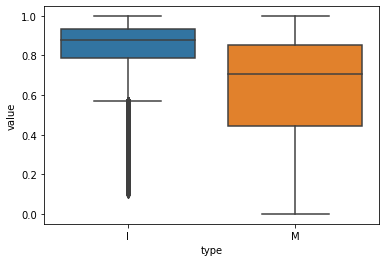

In [ ]:
tmp = pd.DataFrame()
tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["by-intensity-pattern-correlation"]
tmp["type"] = ["I"]*len(tmp)
tmp2 = pd.DataFrame()
tmp2["value"] = fragger[(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)]["corr"]
tmp2["type"] = ["M"]*len(tmp2)
tmp = pd.concat([tmp,tmp2])
sns.boxplot(x="type",y="value",data=tmp)


In [ ]:
fragger[(fragger["sfile"]=="b1906_293T_proteinID_01A_QE3_122212")&(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)&(fragger["corr"]<0.4)].to_csv("check.csv",index=False)

I look at the DeepLC retention error for the PSMs unqiue to each search engine:

<AxesSubplot:xlabel='type', ylabel='value'>

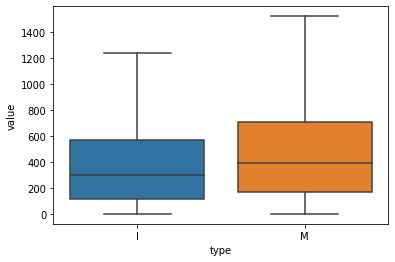

In [ ]:
tmp = pd.DataFrame()
tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["rt-pred-error"]
tmp["type"] = ["I"]*len(tmp)
tmp2 = pd.DataFrame()
tmp2["value"] = fragger[(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)]["rt_diff_A"]
tmp2["type"] = ["M"]*len(tmp2)
tmp = pd.concat([tmp,tmp2])
sns.boxplot(x="type",y="value",data=tmp, showfliers=False)

Next I read the results from the MSFragger Percolator pipeline (see SOP).

I do this by merging the Percolator results with the .tsv results files written by MSFragger as well.

In [ ]:
#read all tsv files into DataFrame
datasets = ionbot["sfile"].unique()
X = []
for ds in datasets:
    d = pd.read_csv("%s/msfragger/%s/%s.tsv"%(folder,dataset,ds),sep="\t")
    d["sfile"] = [ds]*len(d)
    X.append(d)

fragger_perc = pd.concat(X)
fragger_perc.rename(columns={'scannum':'scan'}, inplace=True)


Thes result files contain decoy hits, so I filter these:

In [ ]:
def is_decoy(x):
    return "decoy_" in x
fragger_perc["is_decoy"] = fragger_perc["protein"].apply(is_decoy)

Next I read the FDR statistics obtained by running percolator in the merged pin file (SOP).

The following reads the Percolator results. For some PSMs Percolator does not return statistics. I set these to 1.

In [ ]:
#add statistics
X = []
with open("%s/msfragger/%s/o"%(folder,dataset)) as f:
    f.readline()
    for row in f:
        l = row.rstrip().split('\t')
        sfile = l[0].split('.')[0]
        scan = int(l[0].split('.')[-2])
        X.append([scan,sfile,float(l[2]),float(l[3])])
stats = pd.DataFrame(X,columns=["scan","sfile","q-value","PEP"])
fragger_perc = fragger_perc.merge(stats,on=["scan","sfile"],how="left")
fragger_perc["q-value"].fillna(1,inplace=True)
fragger_perc["PEP"].fillna(1,inplace=True)

In [ ]:
fragger_perc = fragger_perc[(fragger_perc["is_decoy"]==False)&(fragger_perc["q-value"]<=0.01)]

As I can run Crystal-C only on pepXML files I need to correct the peptides and massdiff (SOP).

For this I use the full pipeline results (that includes Crystal-C) and then map these corrected matches back.

In [ ]:
tmp = fragger[["scan","sfile","Peptide","Delta Mass"]]
fragger_perc = fragger_perc.merge(tmp,on=["scan","sfile"],how="left")

For some PSMs there are missing PSMs in the full results:

In [ ]:
fragger_perc[["Peptide","Delta Mass"]].isna().sum()

Peptide       13035
Delta Mass    13035
dtype: int64

So I copy the original values into the missing values.

In [ ]:
fragger_perc['Peptide'] = fragger_perc.apply(
    lambda row: row['peptide'] if pd.isnull(row['Peptide']) else row['Peptide'],
    axis=1
)
fragger_perc['Delta Mass'] = fragger_perc.apply(
    lambda row: row['massdiff'] if np.isnan(row['Delta Mass']) else row['Delta Mass'],
    axis=1
)

This is the PSM overlap for the Percolator version of MSFragger:

In [ ]:
fragger_perc["PSM"] = fragger_perc["scan"].astype(str) + fragger_perc["sfile"] + fragger_perc["Peptide"].apply(replace_L_I)
s1 = set(ionbot["PSM"])
s2 = set(fragger_perc["PSM"])

print(len(s1))
print(len(ionbot[ionbot["rank"]=="first"]))
print(len(s2))

print("ionbot+:\t%i"%len(s1.difference(s2)))
print("intersection:\t%i"%len(s1.intersection(s2)))
print("MSFraggerPercolator:\t%i"%len(s2.difference(s1)))

734334
706510
684959
ionbot+:	171834
intersection:	562500
MSFraggerPercolator:	122459


Next I create .peprec files to run ionbot on these MSFragger PSMs.

In [ ]:
tmp = fragger[["scan","sfile","Spectrum"]]
fragger_perc = fragger_perc.merge(tmp,on=["scan","sfile"],how="left")

Issue here is that there are still missing titles:

In [ ]:
fragger_perc[["Spectrum"]].isna().sum()

Spectrum    13035
dtype: int64

So I have to construct these:

In [ ]:
def construct_title(x):
    return x["sfile"] + '.' + str(x["scan"]).zfill(5) + '.' + str(x["scan"]).zfill(5) + '.' + str(x["charge"])

def correct_title_for_mgf(x):
    tmp = x.split('.')
    return tmp[0] + '.' + tmp[1].lstrip("0") + '.' + tmp[1].lstrip("0") + '.' + tmp[3]

fragger_perc["spectrum_title"] = fragger_perc.apply(construct_title,axis=1) 
#there are still issues with charges that have been recalibrated
#note that these are not recallibrated in ionbot
#I need the original title to make it correspond to the spectrum file title (short version -> need to adjust ionbot code temporarily)
fragger_perc['spectrum_title'] = fragger_perc.apply(
    lambda row: row['Spectrum'] if (row['Spectrum'] != row["spectrum_title"]) & (pd.isna(row['Spectrum'])==False) else row['spectrum_title'],
    axis=1
)
fragger_perc["spectrum_title"] = fragger_perc["spectrum_title"].apply(correct_title_for_mgf)

In [ ]:
s1 = set(fragger["PSM"])
s2 = set(fragger_perc["PSM"])

print(len(s1.difference(s2)))
print(len(s1.intersection(s2)))
print(len(s2.difference(s1)))

100262
671924
13035


I already have the corr and rt statistics for most of them, don't need to reprocess.

In [ ]:
s = s2.difference(s1)
fragger_perc["unique"] = fragger_perc["PSM"].apply(is_in_s)

In [ ]:
#def construct_title2(x):
#    return "controllerType=0 controllerNumber=1 scan=%i"%x
#fragger_perc["ctitle"] = fragger_perc["scan"].apply(construct_title2)    

#sfiles = fragger_perc["sfile"].unique()
#for sf in sfiles:
#    D = fragger_perc[fragger_perc["sfile"]==sf]
#    D["modifications"] = D["modification_info"].apply(convert_mods)
#    if dataset == "PXD001468":
#        tmp = D[np.abs(D["Delta Mass"])<0.5][["Spectrum","modifications","peptide","charge"]]
#    else:
#        tmp = D[np.abs(D["Delta Mass"])<0.5][["ctitle","modifications","peptide","charge"]]
#    tmp.columns = ["spec_id","modifications","peptide","charge"]
#    tmp["peptide"] = tmp["peptide"].apply(correct_peptide)
#    tmp.to_csv("%s_fragger.peprec2"%sf,index=False,sep=" ")

/tmp/ipykernel_1156090/971895341.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D["modifications"] = D["modification_info"].apply(convert_mods)


I read the ionbot results and merge the MS2PIP correlation and LC retention time error with the MSFragger results:

In [ ]:
#sfiles = fragger["sfile"].unique()
#X = []
#for sf in sfiles:
#    tmp = pd.read_csv("%s/%s_fragger.peprec2_ionbotpeprec2/ionbot.csv"%(data_folder,sf))
#    tmp["sfile"] = [sf]*len(tmp)
#    X.append(tmp)
#fragger_stats = pd.concat(X)

#def get_title(x):
#    return int(x.split("scan=")[1][:-1])

#def get_sfile(x):
#    return x.split(".")[0]

#fragger_stats["scan"] = fragger_stats["title"].apply(get_title)
#fragger_stats["sfile"] = fragger_stats["title"].apply(get_sfile)

fragger_stats = fragger[["scan","sfile","corr","rt_diff_A"]]
fragger_perc = fragger_perc.merge(fragger_stats,on=["scan","sfile"],how="left")

This is the PSM overlap:

In [ ]:
s1 = set(ionbot["PSM"])
s2 = set(fragger_perc["PSM"])

print(len(s1))
print(len(s2))

print(len(s1.difference(s2)))
print(len(s1.intersection(s2)))
print(len(s2.difference(s1)))


734334
684959
171834
562500
122459


Let's look at the PSM properties for each of the sections again:

In [ ]:
s = set(s2.difference(s1))
fragger_perc["unique"] = fragger_perc["PSM"].apply(is_in_s)
s = set(s1.difference(s2))
ionbot["unique"] = ionbot["PSM"].apply(is_in_s)
s = set(s1.intersection(s2))
ionbot["intersection"] = ionbot["PSM"].apply(is_in_s)

<AxesSubplot:xlabel='type', ylabel='value'>

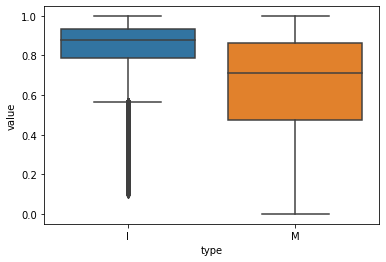

In [ ]:
tmp = pd.DataFrame()
tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["by-intensity-pattern-correlation"]
tmp["type"] = ["I"]*len(tmp)
tmp2 = pd.DataFrame()
tmp2["value"] = fragger_perc[(np.abs(fragger_perc["massdiff"])<0.05)&(fragger_perc["unique"]==True)]["corr"]
tmp2["type"] = ["M"]*len(tmp2)
tmp = pd.concat([tmp,tmp2])
sns.boxplot(x="type",y="value",data=tmp)

<AxesSubplot:xlabel='type', ylabel='value'>

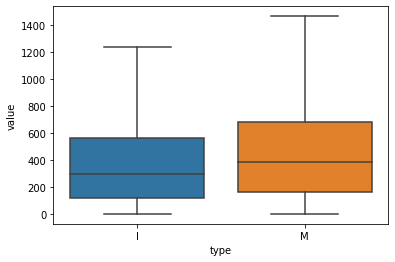

In [ ]:
tmp = pd.DataFrame()
tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["rt-pred-error"]
tmp["type"] = ["I"]*len(tmp)
tmp2 = pd.DataFrame()
tmp2["value"] = fragger_perc[(np.abs(fragger_perc["massdiff"])<0.05)&(fragger_perc["unique"]==True)]["rt_diff_A"]
tmp2["type"] = ["M"]*len(tmp2)
tmp = pd.concat([tmp,tmp2])
sns.boxplot(x="type",y="value",data=tmp, showfliers=False)

In [ ]:
ionbot_proteins_first = pd.read_csv("%s/ionbot.first.proteins.csv"%folder2)
ionbot_proteins_first = ionbot_proteins_first[ionbot_proteins_first["protein_group_q-value"]<=0.01]
pfirst = set(ionbot_proteins_first["protein_group"])
print("#protein-groups for ionbot: %i"%len(pfirst))
ionbot_proteins_coeluting = pd.read_csv("%s/ionbot.coeluting.proteins.csv"%folder2)
ionbot_proteins_coeluting = ionbot_proteins_coeluting[ionbot_proteins_coeluting["protein_group_q-value"]<=0.01]
pco = set(ionbot_proteins_coeluting["protein_group"])
print("#protein-groups for ionbot+: %i"%len(pco))
print("#at the intersection of these: %i"%len(pfirst.intersection(pco)))
fragger_proteins_full = pd.read_csv("%s/msfragger/%s/withprotein/protein.tsv"%(folder,dataset),sep="\t")
print("#protein-groups for MSFraggerPropher: %i"%len(fragger_proteins_full))
fragger_proteins_perc = pd.read_csv("%s/msfragger/%s/proteins.csv"%(folder,dataset),sep="\t")
print("#protein-groups for MSFraggerPercolator: %i"%len(fragger_proteins_perc[fragger_proteins_perc["q-value"]<=0.01]))

#protein-groups for ionbot: 9511
#protein-groups for ionbot+: 9522
#at the intersection of these: 9471
#protein-groups for MSFraggerPropher: 9669
#protein-groups for MSFraggerPercolator: 9466
